About **pobm** library indicated in the article by **Levy et al**.
- Documentation : https://oximetry-toolbox.readthedocs.io/en/latest/
- Code : https://github.com/aim-lab/Oximetry_Toolbox.git
- Installation : $\verb|pip install pobm|$

In [2]:
from pobm.prep import *
from pobm.obm.desat import DesaturationsMeasures
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering


KeyboardInterrupt



In [3]:
import pandas as pd

In [4]:
# load data
data = pd.read_csv("patients_test.csv")
data.head()

,patientsID,channel,signals,Complete_time,Temps_écoulé,Evènement,Durée,Evènement_Apnée Centrale,Evènement_Apnée Obstructive,Evènement_Hypopnée,Evènement_hypopnée Centrale
0,PA1011,SAT,97.498512,2015-09-10 23:44:48,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,PA1011,SAT,97.498512,2015-09-10 23:44:49,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,PA1011,SAT,97.498512,2015-09-10 23:44:50,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,PA1011,SAT,97.498512,2015-09-10 23:44:51,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,PA1011,SAT,97.498512,2015-09-10 23:44:52,NaN,NaN,NaN,0.0,0.0,0.0,0.0


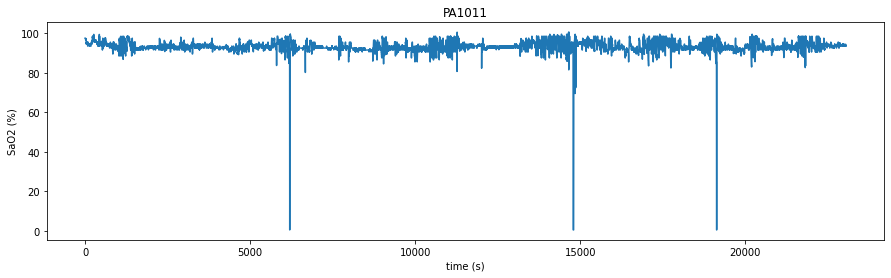

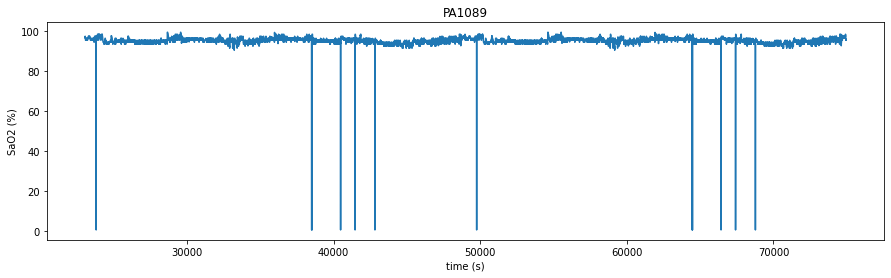

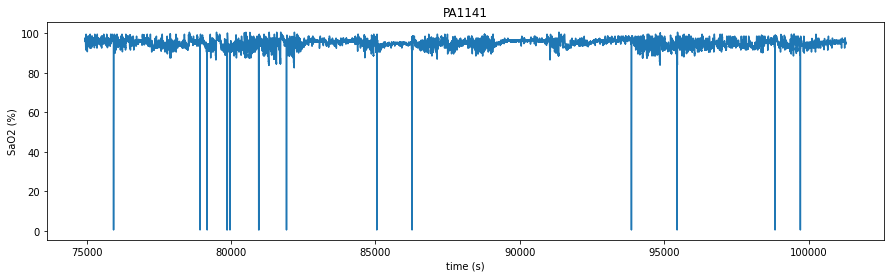

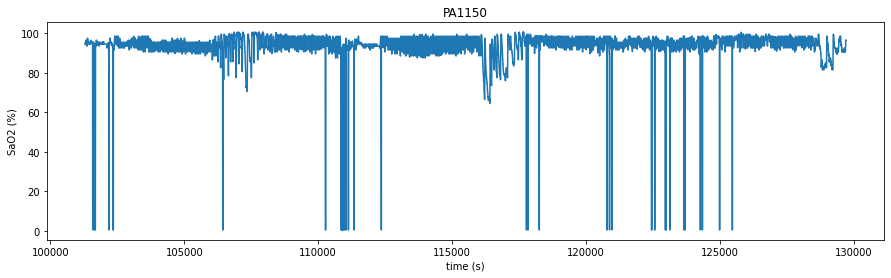

In [5]:
# Display signals
patients = (data["patientsID"]).unique()
sigs = [[]]*4
for px in range(len(patients)):
    sigs[px] = data[data["patientsID"] == patients[px]]["signals"]

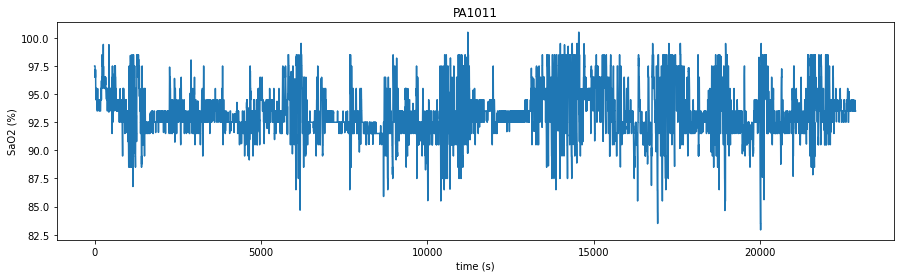

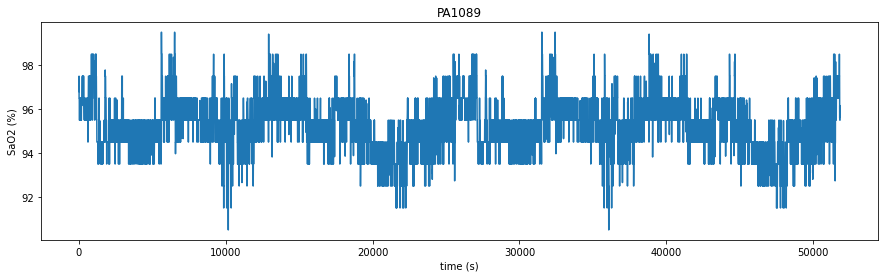

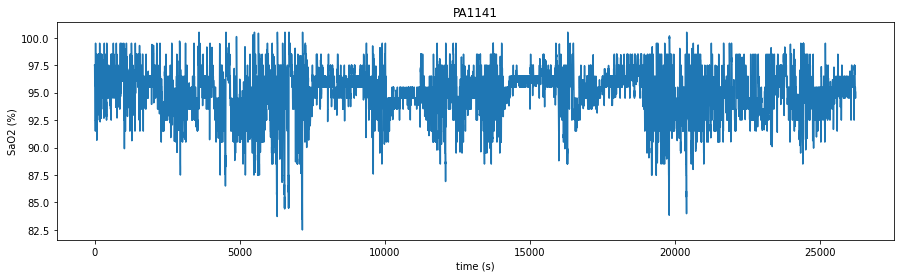

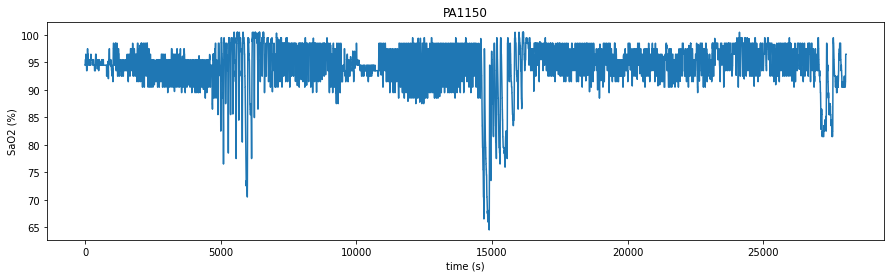

In [6]:
# Prefiltring : Filter signals Using delta filter
filtred_sigs = [[]] * len(patients)
for px in range(len(sigs)):
    filtred_sigs[px] = dfilter(sigs[px])
    plt.figure(figsize=(15, 4))
    plt.plot(filtred_sigs[px])
    plt.title(patients[px])
    plt.xlabel('time (s)')
    plt.ylabel('SaO2 (%)')

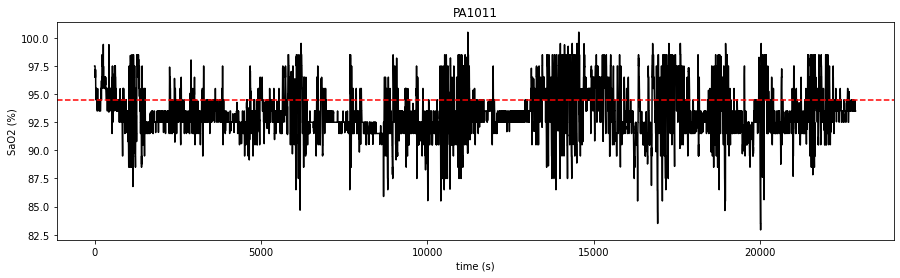

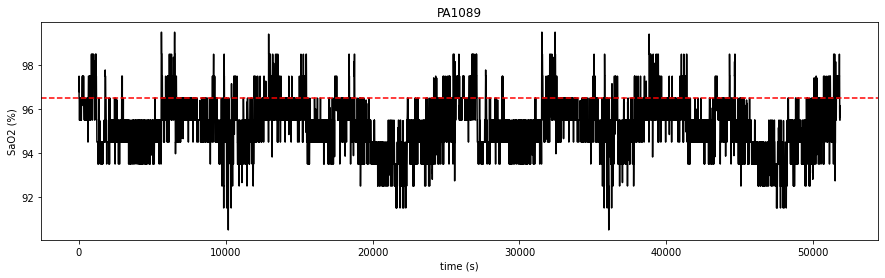

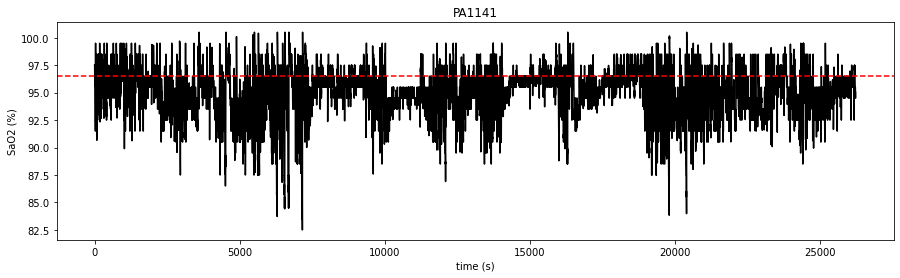

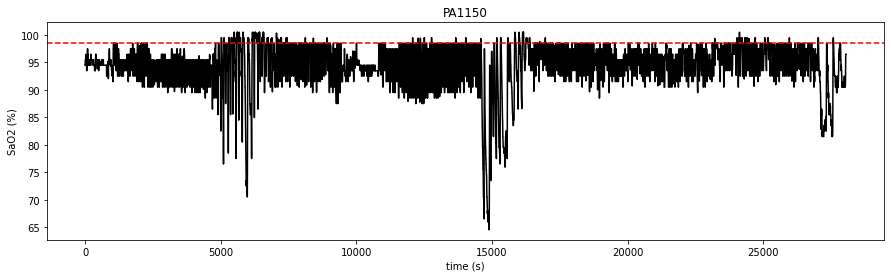

In [7]:
# Baseline for each patient
m = []
for px in range(len(patients)):
    sig = np.array(filtred_sigs[px])
    plt.figure(figsize=(15, 4))
    plt.plot(sig,c = "black")
    m.append(np.quantile(sig[:-1][(np.abs(np.diff(sig)) == 0)],0.8))
    plt.axhline(m[px], color="red", linestyle='dashed') 
    plt.title(patients[px])
    plt.xlabel('time (s)')
    plt.ylabel('SaO2 (%)')
    plt.show()

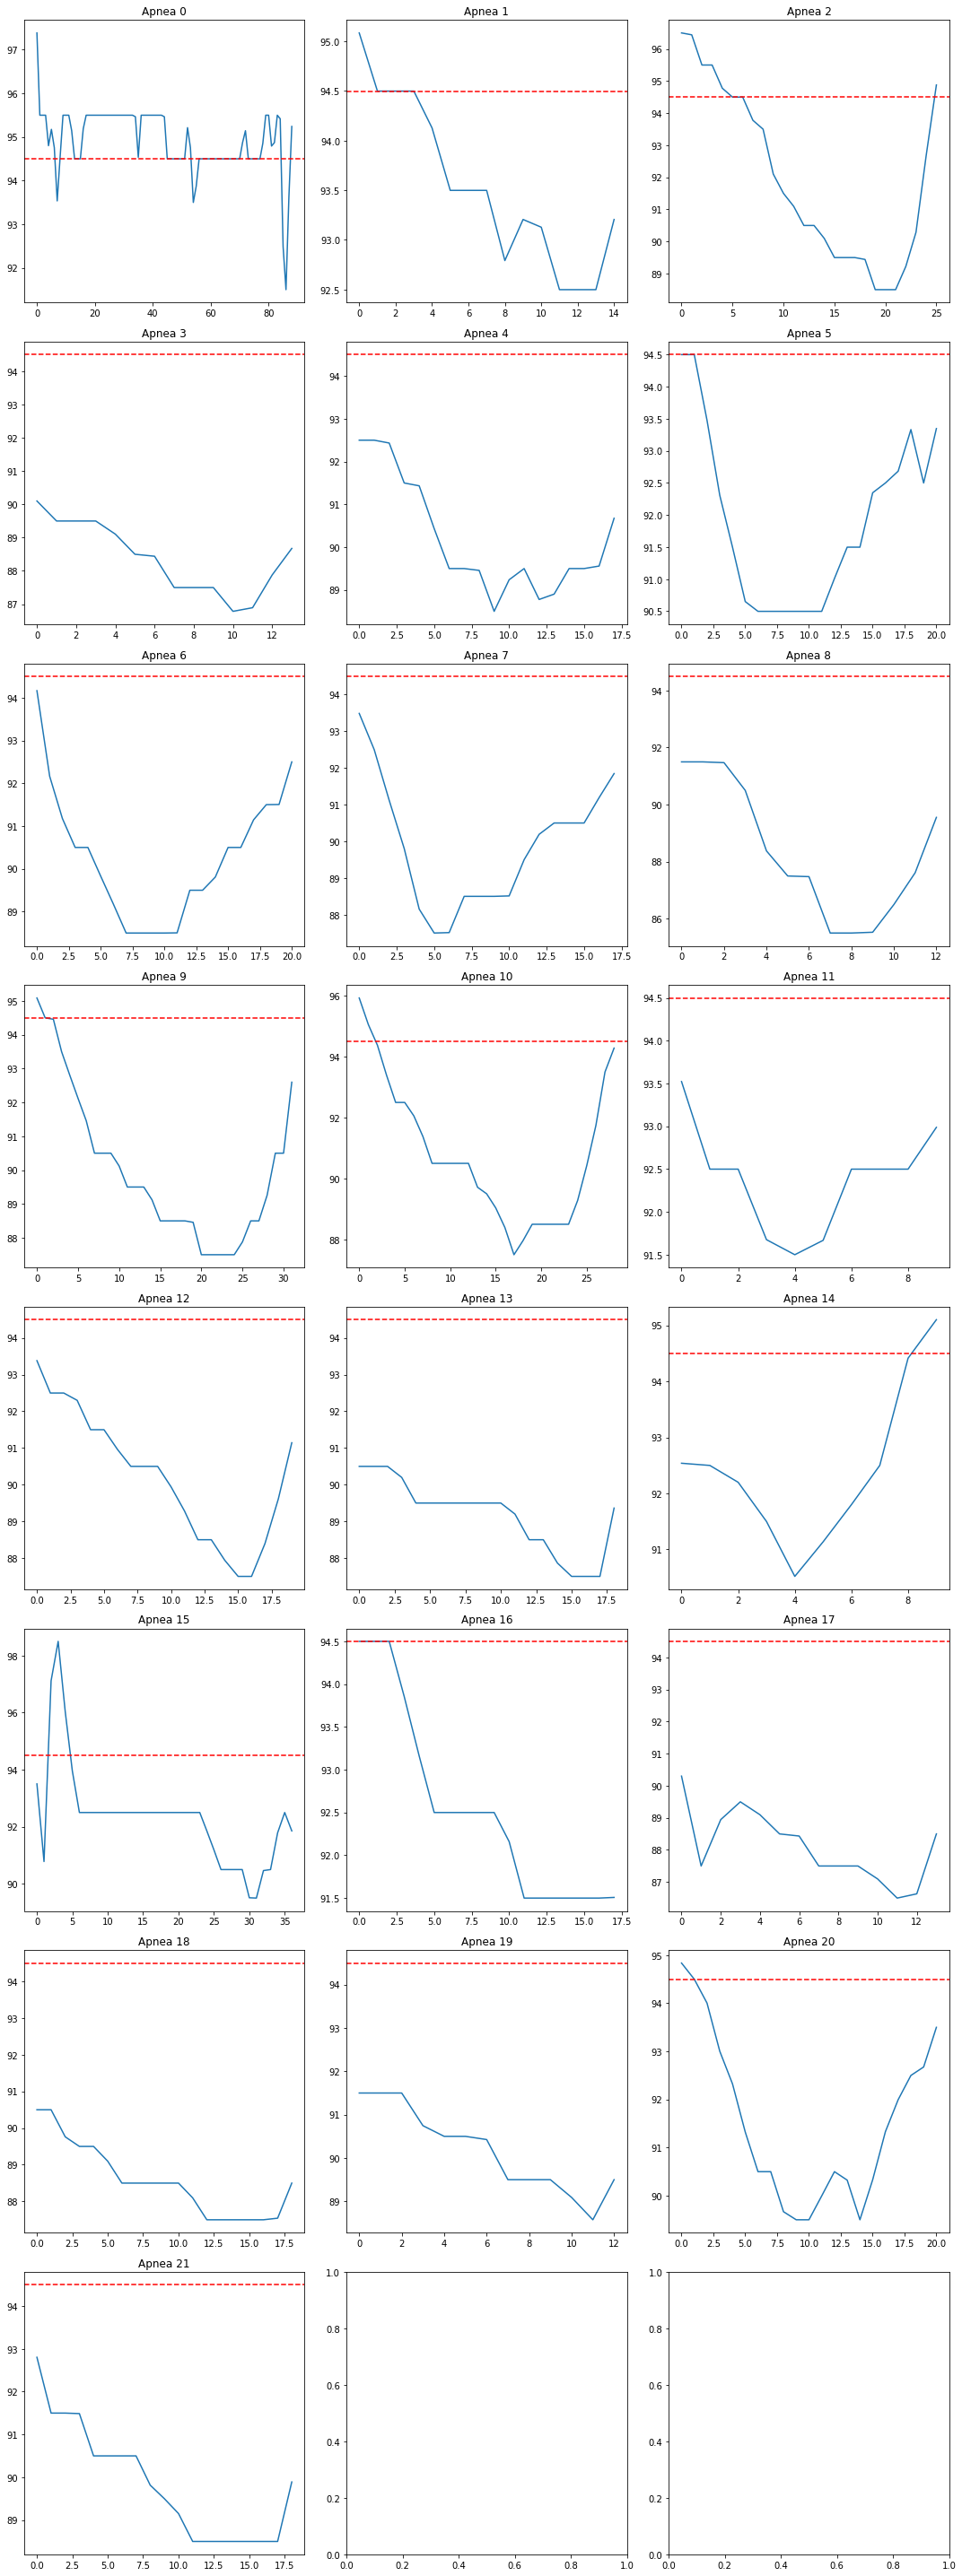

no apneas detected for  PA1089


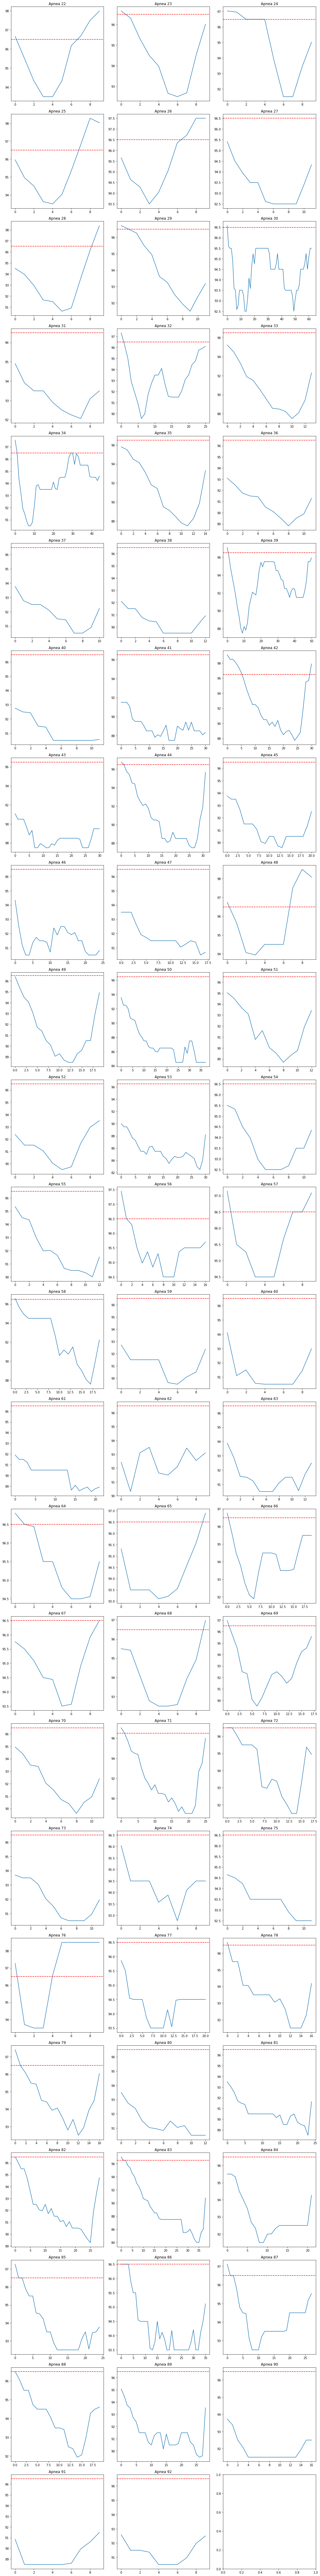

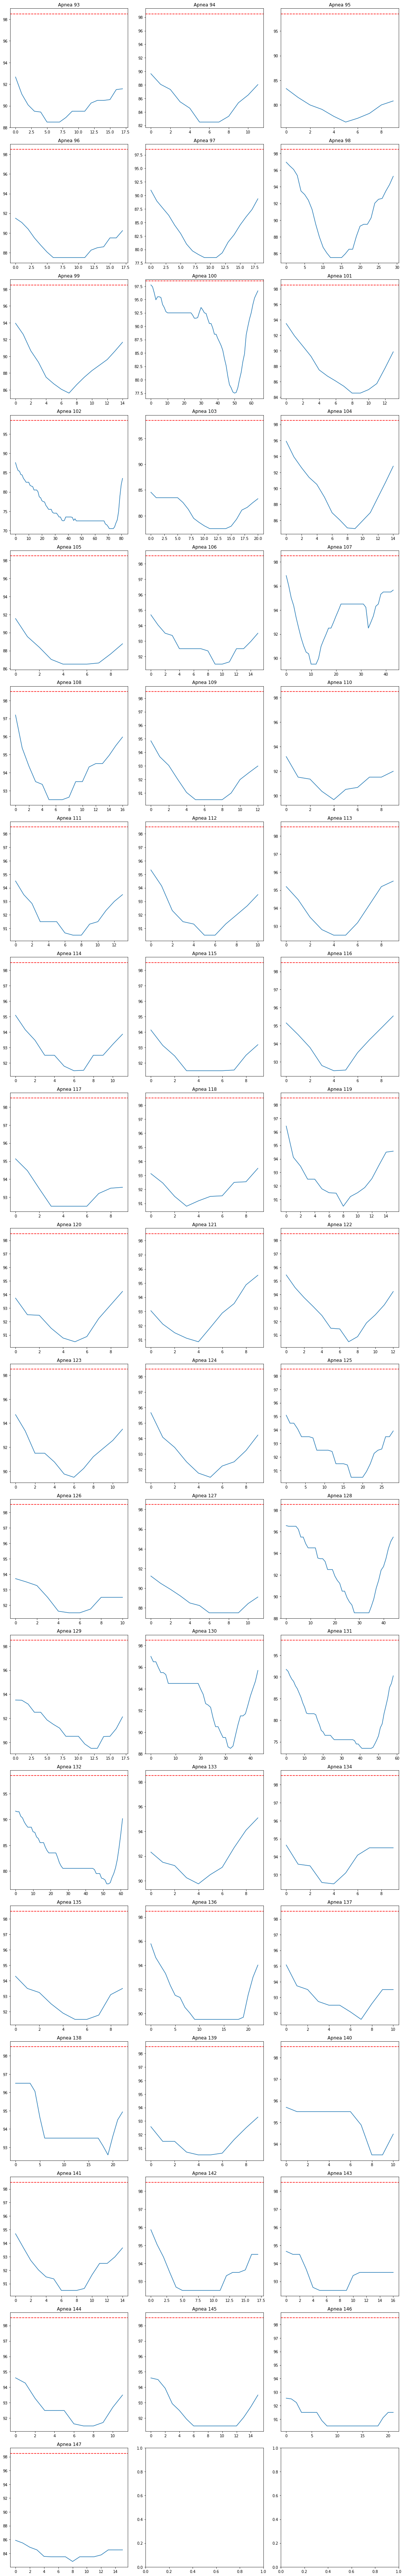

In [64]:
# Calculate desaturations for each patient
columns = ["patient","DL","DD100","DDmax","Dslope","DA100","DAmax", "DLa","DLb"]
apneas_obm = pd.DataFrame(columns = columns)
apneas = []
ix = 0
for px in range(len(patients)):
    desat_class = DesaturationsMeasures(ODI_Threshold=2,desat_max_length=90)
    results_desat = desat_class.compute(filtred_sigs[px])
    n_apneas = len(results_desat.begin)
    if(n_apneas>0):
        num_cols = 3
        num_rows = (n_apneas + num_cols - 1) // num_cols  
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5)) 
        for i in range(n_apneas):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            apnee = filtred_sigs[px][results_desat.begin[i]-10:results_desat.end[i]+10]
            apneas.append(apnee[10:-10])
            ax.plot(apnee[10:-10])
            ax.axhline(m[px], color="red", linestyle='dashed') 
            ax.set_title(f"Apnea {ix}")
            desat_class = DesaturationsMeasures(ODI_Threshold=2)
            obm = desat_class.compute(apnee) 
            new_row = [patients[px],obm.DL_u,obm.DD100_u,obm.DDmax_u,obm.DS_u,obm.DA100_u,obm.DAmax_u,obm.DL_a_u,obm.DL_b_u]
            apneas_obm.loc[ix] = new_row
            ix = ix + 1
        plt.tight_layout()
        plt.show()
    else : 
        print("no apneas detected for ",patients[px])

In [65]:
## Why na slope nor replaced in pobm code !
## remove it , TODO later
data  = apneas_obm.drop("Dslope", axis=1)
data = data.iloc[:,1:]

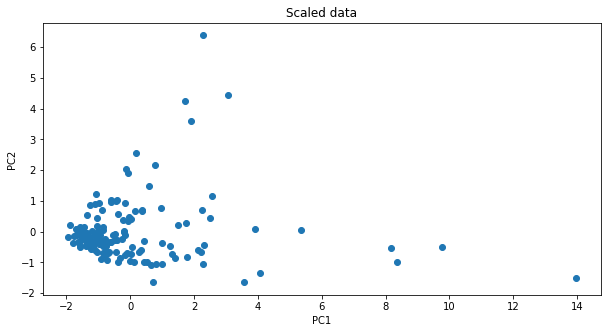

In [94]:
# Perform a PCA on data 
scaler = StandardScaler() ## to center add with_means = True
scaled_data = scaler.fit_transform(data)
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 5))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scaled data')
plt.show()

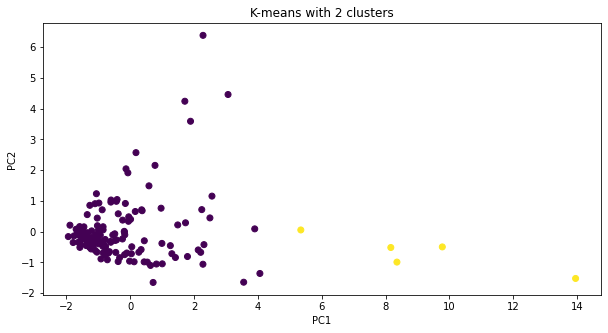

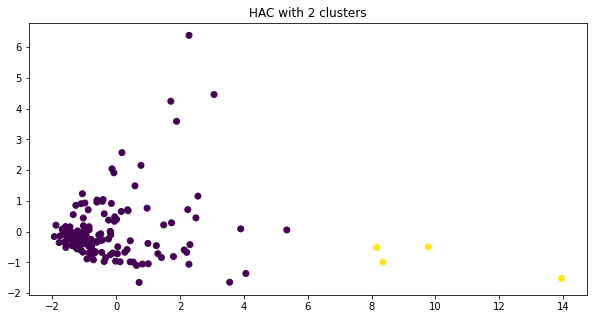

In [99]:
num_clusters = 2  
# K-means
kmeans = KMeans(num_clusters,n_init = 10)
kmeans.fit(scaled_data)
cluster_labels = kmeans.labels_
plt.figure(figsize=(10, 5))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1],c = cluster_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means with 2 clusters')
plt.show()
#class1 = np.where(cluster_labels ==1 )
#class1
# HAC 
hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
cluster_labels = hierarchical.fit_predict(scaled_data)
plt.figure(figsize=(10, 5))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1],c = cluster_labels)
plt.title('HAC with 2 clusters')
plt.show()

In [ ]:
## why !!!!!!!!